
# Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.


# Описание файла с гипотезами : 
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.


# Описание заказов:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.


# Описание пользовательского датасета:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста



# Ход работы: 

1. Предобработка данных
2. Приоритизация гипотез.

    - У нас есть 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами `Reach`, `Impact`, `Confidence`, `Effort`.

**Задача**

    - Применим фреймворки `ICE`  и `RICE` для приоритизации гипотез. Отсортируем их по убыванию приоритета.
    - Посмотрим, как изменилась приоритизация гипотез при применении `RICE` вместо `ICE`.


3. Анализ A/B-теста

    - Мы провели A/B-тест и получили результаты, которые описаны в файлах orders.csv и visitors.csv

**Задача**

Проанализируем A/B-тест:

1. Построим график кумулятивной выручки по группам. 
2. Построим график кумулятивного среднего чека по группам. 
3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 
4. Построим график кумулятивной конверсии по группам.
5. Построим график относительного изменения кумулятивной конверсии группы B к группе A. 
6. Построим точечный график количества заказов по пользователям. 

**сделаем выводы и предположения**

7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.
8. Построим точечный график стоимостей заказов. 
9. Посчитаем 95-й и 99-й перцентили стоимости заказов. Также выберем границу аномалий
10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным
11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 
13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

14. Примем решение по результатам теста. 

    - Варианты решений: 
    1. Остановить тест, зафиксировать победу одной из групп. 
    
    2. Остановить тест, зафиксировать отсутствие различий между группами. 
    
    3. Продолжить тест.

## Предобработка данных

In [25]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st


In [26]:
hpt = pd.read_csv('hypothesis.csv') # файл с гипотезами
display(hpt.info())
visitors = pd.read_csv('visitors.csv') # датасет с данными о пользователях в каждой группе
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [27]:
orders = pd.read_csv('orders.csv')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


<div class="alert alert-info"> 
Видим что нет пропусков, проведём проверку на дубликаты
</div>

In [28]:
# приведём к нижнему регистру колонки
# приведём к типу даты везде где надо

hpt.columns = [x.lower() for x in hpt.columns.values]
visitors.date = pd.to_datetime(visitors.date)
orders.date = pd.to_datetime(orders.date)

In [29]:
# проверим на дубликаты
display(hpt.duplicated().sum())
display(visitors.duplicated().sum())
display(orders.duplicated().sum())

0

0

0

In [30]:
# проверим что каждый пользователь принадлежит только одной группе
users_ab = set(orders[orders['group'] == "A"]['visitorId'].values).intersection(set(orders[orders['group'] \
                                                                         == "B"]['visitorId'].values))
orders[orders['visitorId'].isin(users_ab)].sort_values(by = 'date')['date'].unique()
# видим что пользователи с августа попали в обе группы

array(['2019-08-01T00:00:00.000000000', '2019-08-02T00:00:00.000000000',
       '2019-08-03T00:00:00.000000000', '2019-08-04T00:00:00.000000000',
       '2019-08-05T00:00:00.000000000', '2019-08-06T00:00:00.000000000',
       '2019-08-07T00:00:00.000000000', '2019-08-08T00:00:00.000000000',
       '2019-08-09T00:00:00.000000000', '2019-08-10T00:00:00.000000000',
       '2019-08-11T00:00:00.000000000', '2019-08-12T00:00:00.000000000',
       '2019-08-13T00:00:00.000000000', '2019-08-14T00:00:00.000000000',
       '2019-08-15T00:00:00.000000000', '2019-08-16T00:00:00.000000000',
       '2019-08-17T00:00:00.000000000', '2019-08-18T00:00:00.000000000',
       '2019-08-19T00:00:00.000000000', '2019-08-20T00:00:00.000000000',
       '2019-08-21T00:00:00.000000000', '2019-08-22T00:00:00.000000000',
       '2019-08-23T00:00:00.000000000', '2019-08-24T00:00:00.000000000',
       '2019-08-25T00:00:00.000000000', '2019-08-26T00:00:00.000000000',
       '2019-08-27T00:00:00.000000000', '2019-08-28

Нужно исключить пользователей которые попали в обе группы, иначе нельзя будет опираться на результаты теста

In [31]:
orders_old = orders.copy()
orders = orders[~orders['visitorId'].isin(users_ab)]
orders
# вместо 1197 у нас теперь 1016 строк

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


## Приоритизация гипотез.
### считаем ICE

ICE score = (Impact x Confidence) / Efforts

In [32]:
pd.options.display.max_colwidth = 1000

hpt['ice'] = hpt['impact'] * hpt['confidence'] / hpt['efforts']
hpt.sort_values(by = 'ice', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


Приоритетные гипотезы : 8, 0, 7, 6

### считаем RICE

In [33]:
hpt['rice'] = hpt['reach'] * hpt['ice']
hpt.sort_values(by = 'rice', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Приоритетные : 7, 2, 0, 6


0,7,6 остаются в приоритете и там и там.:

- 7: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- 2:  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- 0:  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- 6: Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию



Метод RICE учитывает охват пользователей (Reach), и оба они учитывают Impact - насколько сильно влияние, Confidence - насколько мы уверены, Efforts - сколько усилий нам нужно

## Анализ A/B-теста
###  Построим график кумулятивной ( то есть накопленной ) выручки по группам. 

In [34]:
date_group = orders[['date', 'group']].drop_duplicates()
date_group

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [35]:
# собираем кумулятивные данные
# к таблице date_group применяем метод apply который внутри себя через lambda возвращает данные orders
ordersAggregated = date_group.apply(lambda x : orders[np.logical_and(orders['group'] == x['group'], \
                                                                     orders['date'] <= x['date'])].agg({
    'date' : 'max',
    'group' : 'max',
    'visitorId' : 'nunique',
    'transactionId' : 'nunique',
    'revenue' : 'sum'
}), axis = 1).sort_values(by = ['date', 'group'])

# аналогично с visitors
visitorsAggregated = date_group.apply(lambda x : visitors[np.logical_and(visitors['group'] == x['group'], \
                                                                         visitors['date'] <= x['date'])].agg({
    'date' : 'max',
    'group' : 'max',
    'visitors' : 'sum',
}), axis = 1).sort_values(by = ['date', 'group'])
# соединяем таблицы 
cumulativeData = ordersAggregated.merge(visitorsAggregated, on = ['date', 'group'])
cumulativeData.columns = ['date', 'group', 'buyers', 'orders', 'revenue', 'visitors']
cumulativeData.head()

,date,group,buyers,orders,revenue,visitors
0,2019-08-01,A,19,23,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,36,42,234381,1338
3,2019-08-02,B,39,40,221801,1294
4,2019-08-03,A,60,66,346854,1845


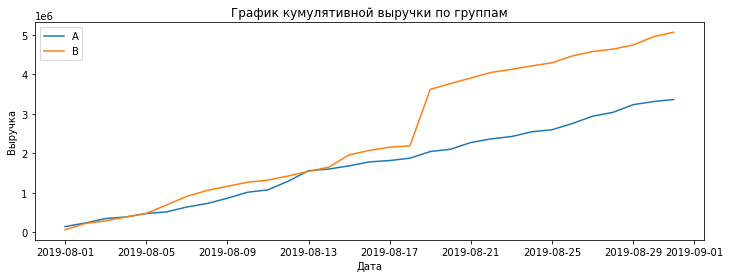

In [36]:
# посчитаем сразу конверсию
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']
#cumulativeData['conversion'] = cumulativeData['buyers'] / cumulativeData['visitors']
# PS мы смотрим конверсию в заказы

#разделяем группы
cumulativeDataA = cumulativeData[cumulativeData['group'] == "A"]
cumulativeDataB = cumulativeData[cumulativeData['group'] == "B"]

plt.figure(figsize = (12,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['revenue'], label = 'A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['revenue'], label = 'B')
plt.xlabel('Дата')
plt.ylabel('Выручка')

plt.title('График кумулятивной выручки по группам')
plt.legend()
print()

Выручка в группе B стабильно выше группы A. Наблюдаем скачок 18-19 числа 

### Построим график кумулятивного среднего чека по группам. 

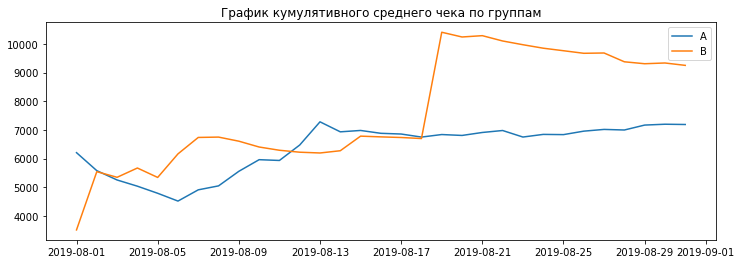

In [37]:
plt.figure(figsize = (12,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['revenue'] / cumulativeDataA['orders'], label = 'A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['revenue'] / cumulativeDataB['orders'], label = 'B')
plt.title('График кумулятивного среднего чека по группам')
plt.legend()
print()

Опять резкий скчок графика группы В 18-19 числа, нужно исследовать на выбросы и тогда делать выводы. После 21 числа средний чек обеих групп выравнивается

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

In [38]:
mergedCumulativeRevenue = cumulativeDataA.merge(cumulativeDataB, on = 'date', how = 'left', suffixes=['A', 'B'])
mergedCumulativeRevenue.head(3)

,date,groupA,buyersA,ordersA,revenueA,visitorsA,conversionA,groupB,buyersB,ordersB,revenueB,visitorsB,conversionB
0,2019-08-01,A,19,23,142779,719,0.031989,B,17,17,59758,713,0.023843
1,2019-08-02,A,36,42,234381,1338,0.031390,B,39,40,221801,1294,0.030912
2,2019-08-03,A,60,66,346854,1845,0.035772,B,53,54,288850,1803,0.029950


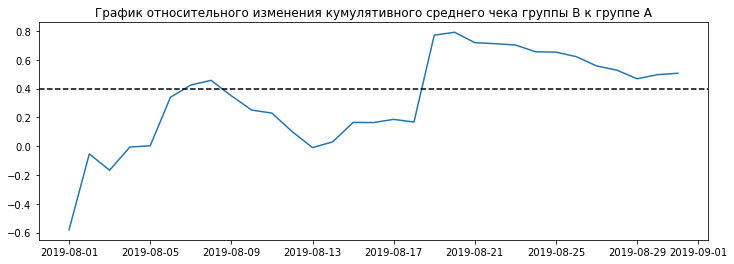

In [39]:
plt.figure(figsize = (12,4))
plt.plot(mergedCumulativeRevenue['date'],\
         (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) / \
         (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersB']) - 1)
plt.axhline(y = 0.4, color = 'black', linestyle = '--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
print()

Есть скачок 18-19 числа, после 21 числа график выравнивается.


Вначале гуппа В проигрывала, но в итоге вырывается вперёд, оставаясь выше группы А на 40%

### Построим график кумулятивной конверсии по группам. 

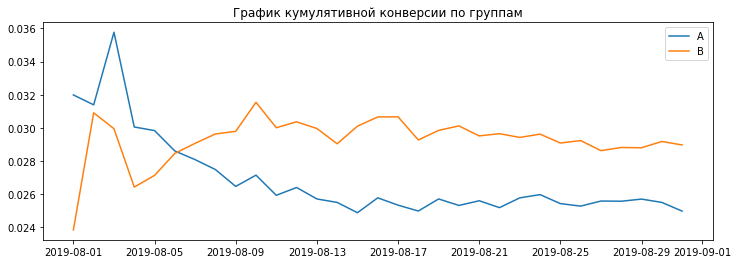

In [40]:
plt.figure(figsize = (12,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label = 'A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label = 'B')
plt.title('График кумулятивной конверсии по группам')
plt.legend()
print()

Конверсия группы B выравнивается, и становиться выше чем конверсия группы A

### Построим график относительного изменения кумулятивной конверсии группы B к группе A. 

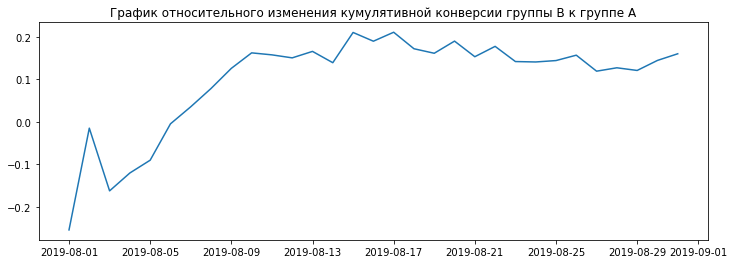

In [41]:
plt.figure(figsize = (12,4))
plt.plot(cumulativeDataA['date'], mergedCumulativeRevenue['conversionB'] / mergedCumulativeRevenue['conversionA'] - 1)

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
print()

Видим колебания конверсии вначале теста, но после 21 числа кумулятивная конверсия группы B к группе A выравнивается. Конверсия группы B стабильно выше

### Построим точечный график количества заказов по пользователям. 

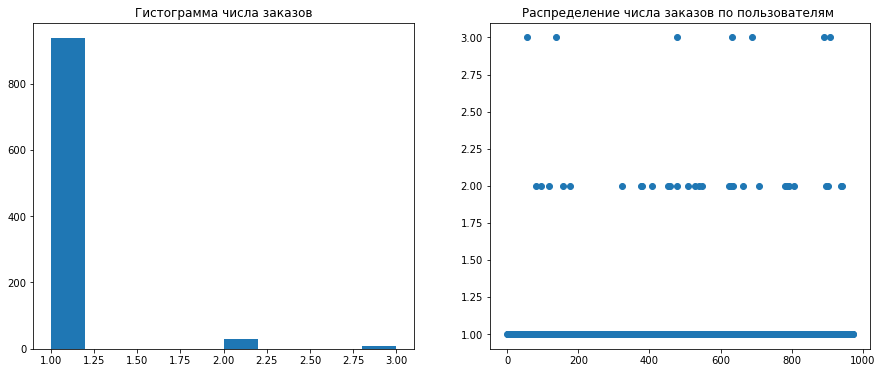

In [42]:
import warnings
warnings.filterwarnings('ignore')

orders_by_user = orders.groupby('visitorId', as_index= False).agg({
    'transactionId' : 'nunique'
})
plt.figure(figsize=(15, 6)) 
plt.subplot(1, 2, 1)
plt.hist(orders_by_user['transactionId'])
plt.title('Гистограмма числа заказов')


plt.subplot(1, 2, 2)
x = pd.Series(range(0, len( orders_by_user['transactionId'])))
plt.scatter(x , orders_by_user['transactionId'])
plt.title('Распределение числа заказов по пользователям ')
plt.subplot(1, 2, 1)
plt.show()


Видим что пользователи в основном заказывают е более 3 товаров

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [43]:
p_99_95 = np.percentile(orders_by_user['transactionId'], [95, 99])
print('95 процентиль = {} . 99 процентиль = {}'.format(p_99_95[0], p_99_95[1]))

95 процентиль = 1.0 . 99 процентиль = 2.0


Пусть границей будет 2 заказа. Пользователей, которые совершают 3+ заказа будем считать аномалиями

### Построим точечный график стоимостей заказов. 

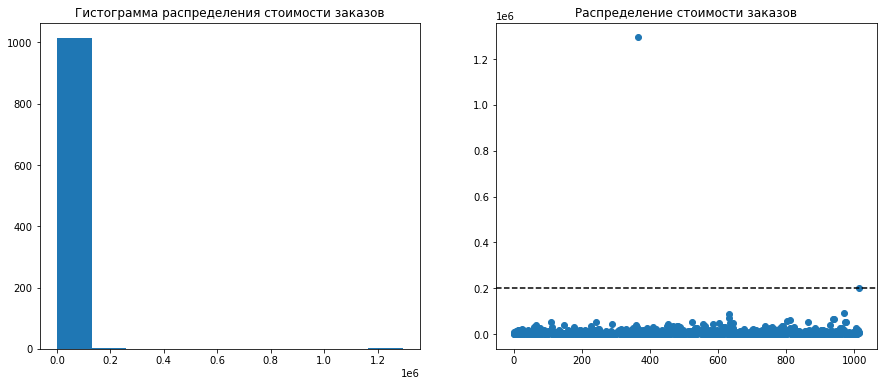

In [44]:

plt.figure(figsize=(15, 6)) 
plt.subplot(1, 2, 1)
plt.hist(orders['revenue'])
plt.title('Гистограмма распределения стоимости заказов')


plt.subplot(1, 2, 2)
x = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x , orders['revenue'])
plt.title('Распределение стоимости заказов')
plt.axhline(y = 0.2e6, color = 'black', linestyle = '--')
plt.subplot(1, 2, 1)
plt.show()

Видим 2 сильных выброса для суммы заказа >= 200 000, это явные аномалии

###  Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [45]:
p_95_99 = np.percentile(orders['revenue'], [95, 99])
print('95 процентиль = {} . 99 процентиль = {}'.format(p_95_99[0], p_95_99[1]))

95 процентиль = 26785.0 . 99 процентиль = 53904.0


Возьмём за границу - 95 процентиль, пользователи которые закуают на большую сумму - аномалии

Составим список id аномальных пользователей

In [46]:
Abnormal_users_id = pd.concat([orders_by_user[orders_by_user['transactionId'] >=3]['visitorId'], \
           orders[orders['revenue'] >= p_95_99[0]]['visitorId']], axis = 0).drop_duplicates()
len(Abnormal_users_id)

58

Всего 58 аномальных пользователя

### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. 

Отфильтруем таблицу orders по группам, для каждой даты сосчитаем число заказов, присоеденим число визитов за этот день

In [24]:
orders_A = orders.query('group == "A"').groupby('date', as_index= False).agg({'transactionId' : 'nunique'})
orders_B = orders.query('group == "B"').groupby('date', as_index= False).agg({'transactionId' : 'nunique'})

orders_A.columns = ['date', 'orders_per_day']
orders_B.columns = ['date', 'orders_per_day']

visitors_A = visitors.query('group == "A"').merge(orders_A, on = ['date'], how = 'left')
visitors_A['conversion'] = visitors_A['orders_per_day'] / visitors_A['visitors']

visitors_B = visitors.query('group == "B"').merge(orders_B, on = ['date'], how = 'left')
visitors_B['conversion'] = visitors_B['orders_per_day'] / visitors_B['visitors']

display(visitors_A.head())
visitors_B.head()

,date,group,visitors,orders_per_day,conversion
0,2019-08-01,A,719,23,0.031989
1,2019-08-02,A,619,19,0.030695
2,2019-08-03,A,507,24,0.047337
3,2019-08-04,A,717,11,0.015342
4,2019-08-05,A,756,22,0.029101


,date,group,visitors,orders_per_day,conversion
0,2019-08-01,B,713,17,0.023843
1,2019-08-02,B,581,23,0.039587
2,2019-08-03,B,509,14,0.027505
3,2019-08-04,B,770,14,0.018182
4,2019-08-05,B,707,21,0.029703


Получим относительную разницу среднего конверсий и p=value по непараметрическому тесту :

    - непараметрический тест, тк мы видели выбросы и у нас много значениий около нуля

<div class="alert alert-info">
Тут и далее: 
    
    
    H_0 - нулевая гипотеза : различия в выборках не являются статистически значимыми
    H_1 - альтернативная гипотеза : выборки различаются 
</div>

In [25]:
alpha = 0.05
# можем взять уже посчитанную одним способом конверсию :
print('Различие : {0:.3f}'.format(visitors_B['conversion'].mean() / visitors_A['conversion'].mean() - 1))
print('p-value = {0:.3f}'.format(st.mannwhitneyu(visitors_A['conversion'], visitors_B['conversion'])[1]))

Различие : 0.175
p-value = 0.054


С p-value = 0.054 не можем отвергнуть нулевую гипотезу о неразличимости выборок. 

То есть если мы возьмем не одну, а 100 выборок, то по каждой мы можем провести отдельный тест и получить случайную величину p-value (100 раз разную). Если мы задали уровень значимости 0.05 и у нас реально нет отличия в средних, то можно ожидать, что в 5 случаях p-value будет достаточно малым, чтобы мы отвергли H0 и допустили ошибку 1-го рода. При этом p-value для ситуаций, когда мы не отвергнем H0 будет случайно болтаться в промежутке от 1 до 0.05. 

In [47]:
# А можем посчитать по другому, Посчитаем количество заказов на покупателя в каждой группе
orders_A_by_user = orders.query('group == "A"').groupby('visitorId', as_index=False).agg({
    'transactionId' : 'nunique'
})
orders_A_by_user.columns = ['visitor_id_A', 'n_orders']

orders_B_by_user = orders.query('group == "B"').groupby('visitorId', as_index=False).agg({
    'transactionId' : 'nunique'
})
orders_B_by_user.columns = ['visitor_id_B', 'n_orders']

# найдём число покупателей которые ничего не заказывали в каждой группе - значит число их заказов = 0
# это сумма числа пользователей за все даты - длина датафрейма с заказами на пользователя 


# соеденим их
sample_A = pd.concat([orders_A_by_user['n_orders'] ,\
pd.Series(0, index = np.arange(visitors.query('group == "A"')['visitors'].sum() - len(orders_A_by_user)))],axis = 0 )


sample_B = pd.concat([orders_B_by_user['n_orders'] ,\
pd.Series(0, index = np.arange(visitors.query('group == "B"')['visitors'].sum() - len(orders_B_by_user)))], axis = 0)

In [29]:
alpha = 0.05

print('Различие : {0:.3f}'.format(sample_B.mean() / sample_A.mean() - 1))
print('p-value = {0:.3f}'.format(st.mannwhitneyu(sample_A, sample_B)[1]))

Различие : 0.160
p-value = 0.011


Уже по сырым данным мы видим что конверсии статистисески значимо отличаются, конверсия во второй группе выше первой на 16%

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

    H_0 - нулевая гипотеза : различия в выборках не являются статистически значимыми
    H_1 - альтернативная гипотеза : выборки различаются 

In [30]:
print('Различие : {0:.3f}'.format(orders[orders['group'] == "B"]['revenue'].mean() / \
                                  orders[orders['group'] == "A"]['revenue'].mean() - 1))
print('p-value = {0:.3f}'.format(st.mannwhitneyu(orders[orders['group'] == "B"]['revenue'],\
                                    orders[orders['group'] == "A"]['revenue'])[1]))

Различие : 0.287
p-value = 0.829


Хоть  и наблюдается относительное отличие в 28 процентов, p-value не позволяет отвергнуть нулевую гипотезу

### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 

In [31]:
# можем посчитать конверсию так :
# отфильтровали аномальных пользователей, сделали то же самое что и ранее

orders_A = orders[np.logical_not(orders['visitorId'].isin(Abnormal_users_id))].query('group == "A"').groupby('date', \
                                                                       as_index= False).agg({'transactionId' : 'nunique'})
orders_B = orders[np.logical_not(orders['visitorId'].isin(Abnormal_users_id))].query('group == "B"').groupby('date', \
                                                                  as_index= False).agg({'transactionId' : 'nunique'})

orders_A.columns = ['date', 'orders_per_day']
orders_B.columns = ['date', 'orders_per_day']

visitors_A = visitors.query('group == "A"').merge(orders_A, on = ['date'], how = 'left')
visitors_A['conversion'] = visitors_A['orders_per_day'] / visitors_A['visitors']

visitors_B = visitors.query('group == "B"').merge(orders_B, on = ['date'], how = 'left')
visitors_B['conversion'] = visitors_B['orders_per_day'] / visitors_B['visitors']


print('Различие : {0:.3f}'.format(visitors_B['conversion'].mean() / visitors_A['conversion'].mean() - 1))
print('p-value = {0:.3f}'.format(st.mannwhitneyu(visitors_A['conversion'], visitors_B['conversion'])[1]))

Различие : 0.194
p-value = 0.040


p-value позволяет нам отвегнуть нулевую гипотезу, относительная разница конверсий изменилась с 17% до 19%

In [32]:
# а можем посчитать конверсию в заказы как среднее число заказов на человека :

# фильтр аномальных пользователей, сделали то же самое что и ранее

orders_f = orders[np.logical_not(orders['visitorId'].isin(Abnormal_users_id))]


# Посчитаем количество заказов на покупателя в каждой группе
orders_A_by_user = orders_f.query('group == "A"').groupby('visitorId', as_index=False).agg({
    'transactionId' : 'nunique'
})
orders_A_by_user.columns = ['visitor_id_A', 'n_orders']

orders_B_by_user = orders_f.query('group == "B"').groupby('visitorId', as_index=False).agg({
    'transactionId' : 'nunique'
})
orders_B_by_user.columns = ['visitor_id_B', 'n_orders']

# найдём число покупателей которые ничего не заказывали в каждой группе - значит число их заказов = 0
# это сумма числа пользователей за все даты - длина датафрейма с заказами на пользователя 

#visitors.query('group == "A"')['visitors'].sum() - len(orders_A_by_user)
#visitors.query('group == "B"')['visitors'].sum() - len(orders_B_by_user)


# соеденим их
sample_A = pd.concat([orders_A_by_user['n_orders'] ,\
pd.Series(0, index = np.arange(visitors.query('group == "A"')['visitors'].sum() - len(orders_A_by_user)))],axis = 0 )


sample_B = pd.concat([orders_B_by_user['n_orders'] ,\
pd.Series(0, index = np.arange(visitors.query('group == "B"')['visitors'].sum() - len(orders_B_by_user)))], axis = 0)

alpha = 0.05

print('Различие : {0:.3f}'.format(sample_B.mean() / sample_A.mean() - 1))
print('p-value = {0:.3f}'.format(st.mannwhitneyu(sample_A, sample_B)[1]))

Различие : 0.182
p-value = 0.012


Различие в конверсиях изменилось с 16% до 18% (у группы B выше)

<div class="alert alert-info">
Можем считать что конверсия группы B значимо выше конверсии группы А
    
</div>

###  Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

In [33]:
orders_filtered_A = orders[np.logical_not(orders['visitorId'].isin(Abnormal_users_id))].query('group == "A"')
orders_filtered_B = orders[np.logical_not(orders['visitorId'].isin(Abnormal_users_id))].query('group == "B"')

print('Различие : {0:.3f}'.format(orders_filtered_A['revenue'].mean() / \
                                  orders_filtered_B['revenue'].mean() - 1))



print('p-value = {0:.3f}'.format(st.mannwhitneyu(orders_filtered_A['revenue'],\
                                    orders_filtered_B['revenue'])[1]))

Различие : 0.051
p-value = 0.646


Всё ещё нет причин отвергать нулевую гипотезу, относительная разность изменилась с 28% до 5%

### Решение по результатам теста.

Варианты решений: 

1. Остановить тест, зафиксировать победу одной из групп. 
2. Остановить тест, зафиксировать отсутствие различий между группами. 
3. Продолжить тест.

Посмотрим на гафики с **фильтрованными данными:**

In [34]:
#отфильтруем данные
orders_filtered = orders[np.logical_not(orders['visitorId'].isin(Abnormal_users_id))]


ordersAggregated = date_group.apply(lambda x : orders_filtered[np.logical_and(orders_filtered['group'] == x['group'], \
                                                                     orders_filtered['date'] <= x['date'])].agg({
    'date' : 'max',
    'group' : 'max',
    'visitorId' : 'nunique',
    'transactionId' : 'nunique',
    'revenue' : 'sum'
}), axis = 1).sort_values(by = ['date', 'group'])


visitorsAggregated = date_group.apply(lambda x : visitors[np.logical_and(visitors['group'] == x['group'], \
                                                                         visitors['date'] <= x['date'])].agg({
    'date' : 'max',
    'group' : 'max',
    'visitors' : 'sum',
}), axis = 1).sort_values(by = ['date', 'group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, on = ['date', 'group'])
cumulativeData.columns = ['date', 'group', 'buyers', 'orders', 'revenue', 'visitors']


# посчитаем сразу конверсию
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']
#cumulativeData['conversion'] = cumulativeData['buyers'] / cumulativeData['visitors']
# PS мы в тренажёре смотрели конверсию в покупки, а не в покупателей

cumulativeDataA = cumulativeData[cumulativeData['group'] == "A"]
cumulativeDataB = cumulativeData[cumulativeData['group'] == "B"]



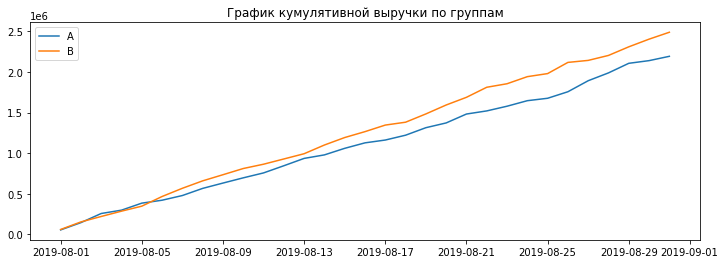

In [35]:
plt.figure(figsize = (12,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['revenue'], label = 'A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['revenue'], label = 'B')
plt.title('График кумулятивной выручки по группам')
plt.legend()
print()

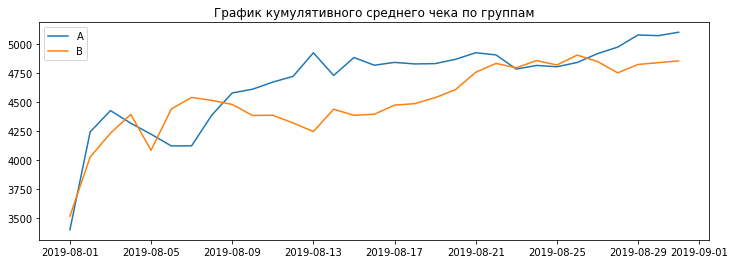

In [36]:
plt.figure(figsize = (12,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['revenue'] / cumulativeDataA['orders'], label = 'A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['revenue'] / cumulativeDataB['orders'], label = 'B')
plt.title('График кумулятивного среднего чека по группам')
plt.legend()
print()

Для кумулятивной выручки и среднего чека мы уже не наблюдаем резких изменеий

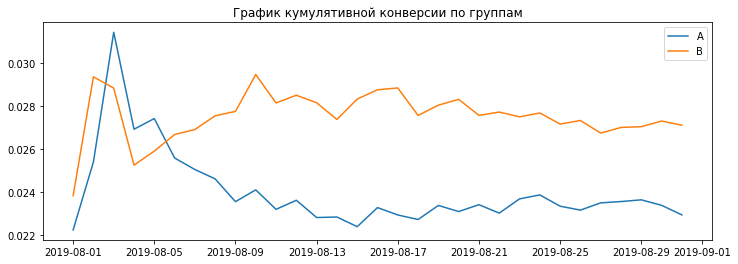

In [37]:
plt.figure(figsize = (12,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label = 'A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label = 'B')
plt.title('График кумулятивной конверсии по группам')
plt.legend()
print()

## Общие выводы по результатам тестов


Видим статистически значимое различие в конверсии между группами по чистым данным, конверсия группы B выше конверсии группы A. (на 18%)
 
* нет значимых различий в среднем чеке по группам
* конверсия группы B значимо больше
* по кумулятивной выручке мы видим что с группы B мы стабильно больше зарабатываем


тест можно **остановить** и признать его успешным